In [1]:
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import scipy


In [2]:
fnames=['ORCA025-SE-NEMO_1990_2019_GS1p2_full_SST_SSS_PEA_MonClimate.nc',
'ORCA025-SE-NEMO_1990_2019_GS1p0_notide_SST_SSS_PEA_MonClimate.nc']
names=['GS1p7_full','GS1p0_notide']

dpath='/home/users/jholt/work/SENEMO/ASSESSMENT/ORCA025-SE-NEMO'
fn_bathymetry='/home/users/jholt/work/SENEMO/senemo/INPUTS/eORCA025_bathy_meter.nc' 

datapath_LME ='/home/users/jholt/work/SENEMO/ASSESSMENT/EN4/'
DATANAME='ORCA025_1978-2019'
#DATANAME='ORCA025'
f_bathy=xr.open_dataset(fn_bathymetry)

J_offset=186 #account for extra rows in eORCA if data is made for normal ORCA
J_offset=0
J_offset_mask=186
A=np.load('../Data/LME_gridinfo_V4.npz')
a=scipy.io.loadmat('../Data/ORCA025_ROAM_GLB_LMEmaskV4.mat')
LME_mask=np.array(a['LME_mask'][:,:].T)

In [3]:
LME_mask.shape

(1021, 1442)

In [4]:
LME_Clusters='../Data/LME_Clusters_eORCA025.csv'
clusters = pd.read_csv(LME_Clusters)
nclusters=clusters.values.shape[0]
iwant_clusters=range(23)

In [5]:
def map_to_grid(Var_in,j_min,j_max,i_min,i_max):
     if len(Var_in.shape)==2:
         if i_max1 > i_min1:
             Var_out=Var_in[j_min:j_max+1,i_min:i_max+1]
         else:
             Var_out1=Var_in[j_min:j_max+1,i_min:-1]
             Var_out2=Var_in[j_min:j_max+1,:i_max+1]
             Var_out=np.concatenate((Var_out1,Var_out2),axis=1)
     else:
         if i_max1 > i_min1:
             Var_out=Var_in[:,j_min:j_max+1,i_min:i_max+1]
         else:
             Var_out1=Var_in[:,j_min:j_max+1,i_min:-1]
             Var_out2=Var_in[:,j_min:j_max+1,:i_max+1]
             Var_out=np.concatenate((Var_out1,Var_out2),axis=2)
     return Var_out

In [6]:
SST_EN4={}
SSS_EN4={}
PEA_EN4={}

for icluster in iwant_clusters:

     lmes=clusters.values[icluster,10:]
     ilmes=np.array([])
     for LME in lmes:
     #try:
     #    ilmes=np.append(ilmes,int(LME[-2:]))
     #except:
     #    ilmes=np.append(ilmes,-1)
        if not type(LME)==float:
             ilmes=np.append(ilmes,int(LME[-2:]))
        else:
             ilmes=np.append(ilmes,-1)

             
     Cluster_Name=clusters.values[icluster,1]
     #eORCA025 index of cluster
     i_min1=int(clusters.values[icluster,2])
     i_max1=int(clusters.values[icluster,3])
     j_min1=int(clusters.values[icluster,4])
     j_max1=int(clusters.values[icluster,5])
     D=map_to_grid(f_bathy.Bathymetry.values,j_min1,j_max1,i_min1,i_max1)

     LMEmask=map_to_grid(LME_mask,j_min1-J_offset_mask,j_max1-J_offset_mask,i_min1,i_max1)
     #if i_max1 > i_min1:
     #    D=f_bathy.Bathymetry.values[j_min1:j_max1+1,i_min1:i_max1+1]
     #    LMEmask=LME_mask[(j_min1-J_offset_mask):(j_max1-J_offset_mask+1),i_min1:i_max1+1]
     #else:
     #    D1 = f_bathy.Bathymetry.values[j_min1:j_max1+1,i_min1:]
     #    D2 = f_bathy.Bathymetry.values[j_min1:j_max1+1,:i_max1+1]
     ##    D=np.concatenate((D1,D2),axis=1)
     #    LMEmask1=LME_mask[(j_min1-J_offset_mask):(j_max1-J_offset_mask+1),i_min1:]
     #    LMEmask2=LME_mask[(j_min1-J_offset_mask):(j_max1-J_offset_mask+1),:i_max1+1]
     #    LMEmask=np.concatenate((LMEmask1,LMEmask2),axis=1)
     nX = f_bathy.Bathymetry.shape[1] - i_min1

    
     Depth=np.repeat(D[np.newaxis,:,:],12,axis=0)
     SST_EN4[icluster]=np.zeros(Depth.shape)
     SSS_EN4[icluster]=np.zeros(Depth.shape)
     PEA_EN4[icluster]=np.zeros(Depth.shape)     
     mask=np.zeros((Depth.shape[1],Depth.shape[2]))
     for ilme,LMENAM in enumerate(lmes):
        if isinstance(LMENAM,str):
                            
            
       # try:
            
            is_file=True
            try:
                #EN4=xr.open_dataset(f"{datapath_LME}/{DATANAME}/{LMENAM}_EN4mnthgrid_V3.nc")
                EN4=xr.open_dataset(f"{datapath_LME}/{DATANAME}/{LMENAM}_1978_2019_EN4_eORCA025_PEA_SST_SSS_v1.nc")
            except:
                is_file=False
                print(f"{datapath_LME}/{DATANAME}/{LMENAM}_EN4_eORCA025_PEA_SST_SSS_V3.nc")
            if is_file:
                #ORCA025 index of LME bounds
                dx=EN4.x_dim.shape[0]-1
                lims=EN4.lims.values
                lims=np.array([lims[2],lims[3],lims[0],lims[1]]) # re-order to i,i,j,j
                #conver to eORCA grid
                lims[[2,3]]=lims[[2,3]] +J_offset

                lims1=np.copy(lims)
                lims1[0]=np.max([lims[0],i_min1])
                lims1[1]=np.min([lims[1],i_max1])
                lims1[2]=np.max([lims[2],j_min1])
                lims1[3]=np.min([lims[3],j_max1])
                print(LMENAM,lims1)
                #index of the LME data
                i_min2=lims1[0]-lims[0]
                i_max2=lims1[1]-lims[0]
                j_min2=lims1[2]-lims[2]
                j_max2=lims1[3]-lims[2]

                    

                #Index of LME portion of CLuster
                i_min=lims1[0]-i_min1
                #lims1[1]-i_min1
                i_max=lims1[1]-i_min1
                j_min=lims1[2]-j_min1
                j_max=lims1[3]-j_min1
                
                if lims[0]>lims[1]:
                    i_max2=dx-1                
                    i_max=i_min + dx-1
                    print(i_max2,i_max,i_min1)
                if lims[0]<lims[1] and i_min1 > i_max1:
                    
                    i_min2=0
                    i_max2=dx-1
                    i_min=lims1[0]-i_min1 + nX
                    i_max=i_min + dx-1
                mask[LMEmask==ilmes[ilme]]=1
                SST_EN4_LME=EN4.sst_g.values[:,:,:]
                SSS_EN4_LME=EN4.sss_g.values[:,:,:]
                PEA_EN4_LME=EN4.pea_g.values[:,:,:]
                #SST_EN4_LME=EN4.SST_g.values[:,:,:].T
                #SSS_EN4_LME=EN4.SSS_g.values[:,:,:].T
                #PEA_EN4_LME=EN4.PEA_g.values[:,:,:].T
                
                SST_EN4_LME[~np.isfinite(SST_EN4_LME)]=0.
                SSS_EN4_LME[~np.isfinite(SSS_EN4_LME)]=0.
                PEA_EN4_LME[~np.isfinite(PEA_EN4_LME)]=0.
                PEA_EN4_LME[PEA_EN4_LME<0]=0.    
                PEA_EN4_LME[PEA_EN4_LME>1000]=0.    
                mm=LMEmask[j_min:j_max+1,i_min:i_max+1]==ilmes[ilme]
                #mm=1
                SST_EN4[icluster][:,j_min:j_max+1,i_min:i_max+1]=(SST_EN4[icluster][:,j_min:j_max+1,i_min:i_max+1]+
                                                                 SST_EN4_LME[:,j_min2:j_max2+1,i_min2:i_max2+1]*mm)
                SSS_EN4[icluster][:,j_min:j_max+1,i_min:i_max+1]=(SSS_EN4[icluster][:,j_min:j_max+1,i_min:i_max+1]+
                                                                  SSS_EN4_LME[:,j_min2:j_max2+1,i_min2:i_max2+1]*mm)
                PEA_EN4[icluster][:,j_min:j_max+1,i_min:i_max+1]=(PEA_EN4[icluster][:,j_min:j_max+1,i_min:i_max+1]+
                                                                  PEA_EN4_LME[:,j_min2:j_max2+1,i_min2:i_max2+1]*mm)
           # except:
           #     continue
    
             
     mask=np.repeat(mask[np.newaxis,:,:],12,axis=0)
    
     SST_EN4[icluster][SST_EN4[icluster]==0]=np.nan
     SSS_EN4[icluster][SSS_EN4[icluster]==0]=np.nan
     PEA_EN4[icluster][PEA_EN4[icluster]==0]=np.nan
     
     SST_EN4[icluster][mask==0]=np.nan
     SSS_EN4[icluster][mask==0]=np.nan
     PEA_EN4[icluster][mask==0]=np.nan

Kara_Sea_58 [1212  318 1155 1205]
547 635 1124
Laptev_Sea_57 [1124  357 1072 1172]
East_Siberian_Sea_56 [1124  401 1035 1119]
Canadian_High_Arctic_-_North_Greenland_66 [ 504  700 1150 1161]
Beaufort_Sea_55 [ 470  700 1085 1145]
Canadian_High_Arctic_-_North_Greenland_66 [ 784 1074 1150 1161]
East_Bering_Sea_01 [401 508 928 985]
Central_Arctic_64 [ 404  457  987 1124]
Aleutian_Islands_65 [396 469 917 936]
West_Bering_Sea_53 [341 424 916 991]
Hudson_Bay_Complex_63 [ 786  908  939 1100]
Canadian_Eastern_Arctic_-_West_Greenland_18 [ 902  981  972 1137]
Labrador_-_Newfoundland_09 [875 976 874 996]
Greenland_Sea_19 [ 981 1115  971 1135]
Norwegian_Sea_21 [1095 1144 1001 1108]
Iceland_Shelf_and_Sea_59 [1033 1104  992 1055]
Barents_Sea_20 [1084 1176 1068 1194]
Yellow_Sea_48 [181 216 822 870]
East_China_Sea_47 [185 232 784 836]
Kuroshio_Current_49 [193 294 772 875]
Sea_of_Japan_50 [220 284 830 941]
Oyashio_Current_51 [284 346 865 921]
Sea_of_Okhotsk_52 [262 374 882 992]
Gulf_of_Alaska_02 [ 503  6

In [7]:
LMEmask.shape

(204, 135)

In [8]:
lims

array([1305, 1356,  645,  728])

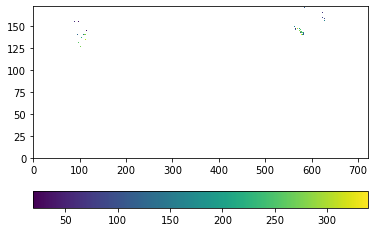

In [9]:
plt.pcolormesh(PEA_EN4[0][6,:,:]);plt.colorbar(orientation='horizontal')


Eurasian Arctic


/tmp/ipykernel_756/3332366337.py:50: RuntimeWarning: Mean of empty slice
  PEA_co_mask_mean[name,icluster][it]=np.nanmean(PEA_co_mask[it,:,:])
/tmp/ipykernel_756/3332366337.py:60: RuntimeWarning: Mean of empty slice
  SSS_co_mask_mean[name,icluster][it]=np.nanmean(SSS_co_mask[it,:,:])
/tmp/ipykernel_756/3332366337.py:71: RuntimeWarning: Mean of empty slice
  SST_co_mask_mean[name,icluster][it]=np.nanmean(SST_co_mask[it,:,:])


W Canadian Arctic
E Canadian Arctic
Bering Sea
NE N America
Nordic Seas
Barents Sea
E Asia
NW N America
W N America
E N America
N Europe
Med, Ibi, Black Seas
SE Asia
C America
NE S America
NW Africa
S Asia
Australia,NZ
W S America
SE S America
SW Africa
E Africa
Eurasian Arctic
W Canadian Arctic
E Canadian Arctic
Bering Sea
NE N America
Nordic Seas
Barents Sea
E Asia
NW N America
W N America
E N America
N Europe
Med, Ibi, Black Seas
SE Asia
C America
NE S America
NW Africa
S Asia
Australia,NZ
W S America
SE S America
SW Africa
E Africa


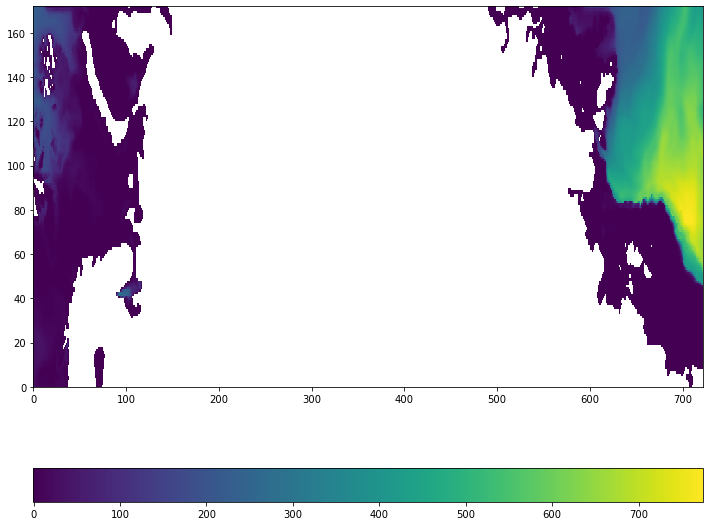

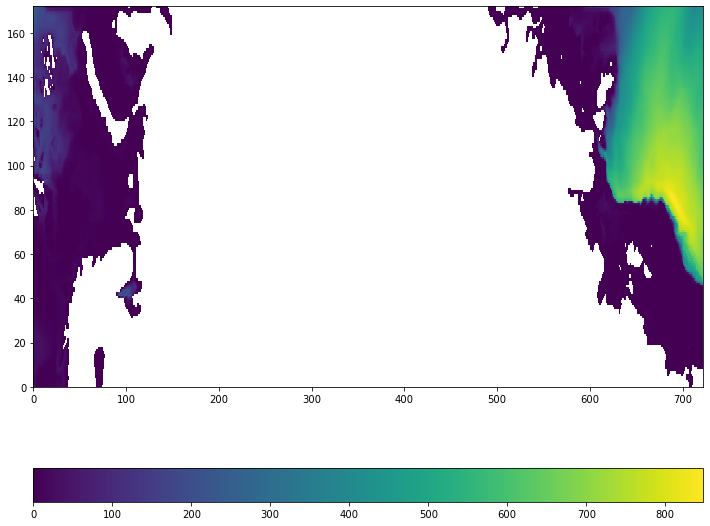

In [10]:
PEA_co_mean={}
SSS_co_mean={}
SST_co_mean={}
PEA_co_mask_mean={}
SSS_co_mask_mean={}
SST_co_mask_mean={}

for iname,fname in enumerate(fnames):
    name=names[iname]
    f=xr.open_dataset(f"{dpath}/{fname}")
    for icluster in range(23):
        print(clusters.values[icluster,1])
        i_min1=int(clusters.values[icluster,2])
        i_max1=int(clusters.values[icluster,3])
        j_min1=int(clusters.values[icluster,4])
        j_max1=int(clusters.values[icluster,5])
        #D=f_bathy.Bathymetry.values[j_min1:j_max1+1,i_min1:i_max1+1]
        D=map_to_grid(f_bathy.Bathymetry.values,j_min1,j_max1,i_min1,i_max1)

        #PEAy=f.pea_monthy_clim.values[:,j_min1:j_max1+1,i_min1:i_max1+1]
        PEAy=map_to_grid(f.pea_monthy_clim.values,j_min1,j_max1,i_min1,i_max1)

        PEA_co=np.copy(PEAy)
        PEA_co_mask=np.copy(PEAy)
        PEA_co_mask[np.isnan(PEA_EN4[icluster])]=np.nan

        #SSSy=f.sss_monthy_clim.values[:,j_min1:j_max1+1,i_min1:i_max1+1]
        SSSy=map_to_grid(f.sss_monthy_clim.values,j_min1,j_max1,i_min1,i_max1)
        SSS_co=np.copy(SSSy)
        SSS_co_mask=np.copy(SSSy)
        SSS_co_mask[np.isnan(SSS_EN4[icluster])]=np.nan

        #SSTy=f.sst_monthy_clim.values[:,j_min1:j_max1+1,i_min1:i_max1+1]
        SSTy=map_to_grid(f.sst_monthy_clim.values,j_min1,j_max1,i_min1,i_max1)
        SST_co=np.copy(SSTy)
        SST_co_mask=np.copy(SSTy)
        SST_co_mask[np.isnan(SST_EN4[icluster])]=np.nan
        
        DD=np.repeat(D[np.newaxis,:,:],12,axis=0)
        DD.shape
        Dcrit=500
        PEA_co[DD>Dcrit]=np.nan
        PEA_co_mask[DD>Dcrit]=np.nan
        
        PEA_co_mean[name,icluster]=np.zeros(12)
        PEA_co_mask_mean[name,icluster]=np.zeros(12)
        
        for it in range(12):
            PEA_co_mean[name,icluster][it]=np.nanmean(PEA_co[it,:,:])
            PEA_co_mask_mean[name,icluster][it]=np.nanmean(PEA_co_mask[it,:,:])

        SSS_co[DD>Dcrit]=np.nan
        SSS_co_mask[DD>Dcrit]=np.nan
        
        SSS_co_mean[name,icluster]=np.zeros(12)
        SSS_co_mask_mean[name,icluster]=np.zeros(12)
        
        for it in range(12):
            SSS_co_mean[name,icluster][it]=np.nanmean(SSS_co[it,:,:])
            SSS_co_mask_mean[name,icluster][it]=np.nanmean(SSS_co_mask[it,:,:])
            
        
        SST_co[DD>Dcrit]=np.nan
        SST_co_mask[DD>Dcrit]=np.nan
        
        SST_co_mean[name,icluster]=np.zeros(12)
        SST_co_mask_mean[name,icluster]=np.zeros(12)
        
        for it in range(12):
            SST_co_mean[name,icluster][it]=np.nanmean(SST_co[it,:,:])
            SST_co_mask_mean[name,icluster][it]=np.nanmean(SST_co_mask[it,:,:])
        if icluster==0:
            plt.figure(figsize=(12,10))
            plt.pcolormesh(PEAy[0,:,:]);plt.colorbar(orientation='horizontal')

/tmp/ipykernel_756/307008002.py:28: RuntimeWarning: Mean of empty slice
  PEA_EN4_co_mean[icluster][it]=np.nanmean(PEA_co[it,:,:])
/tmp/ipykernel_756/307008002.py:29: RuntimeWarning: Mean of empty slice
  SSS_EN4_co_mean[icluster][it]=np.nanmean(SSS_co[it,:,:])
/tmp/ipykernel_756/307008002.py:30: RuntimeWarning: Mean of empty slice
  SST_EN4_co_mean[icluster][it]=np.nanmean(SST_co[it,:,:])


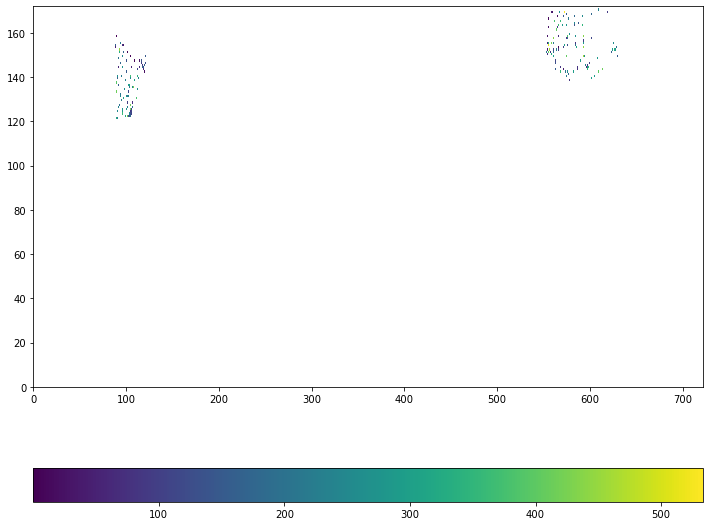

In [11]:
PEA_EN4_co_mean={}
SSS_EN4_co_mean={}
SST_EN4_co_mean={}

for icluster in range(23):

    i_min1=int(clusters.values[icluster,2])
    i_max1=int(clusters.values[icluster,3])
    j_min1=int(clusters.values[icluster,4])
    j_max1=int(clusters.values[icluster,5])
    #D=f_bathy.Bathymetry.values[j_min1:j_max1+1,i_min1:i_max1+1]
    
    PEA_co=np.copy(PEA_EN4[icluster])
    SSS_co=np.copy(SSS_EN4[icluster])
    SST_co=np.copy(SST_EN4[icluster])
    D=map_to_grid(f_bathy.Bathymetry.values,j_min1,j_max1,i_min1,i_max1)
    DD=np.repeat(D[np.newaxis,:,:],12,axis=0)

    PEA_co[DD>Dcrit]=np.nan
    SSS_co[DD>Dcrit]=np.nan
    SST_co[DD>Dcrit]=np.nan
    
    PEA_EN4_co_mean[icluster]=np.zeros(12)
    SSS_EN4_co_mean[icluster]=np.zeros(12)
    SST_EN4_co_mean[icluster]=np.zeros(12)
    
    for it in range(12):
        PEA_EN4_co_mean[icluster][it]=np.nanmean(PEA_co[it,:,:])
        SSS_EN4_co_mean[icluster][it]=np.nanmean(SSS_co[it,:,:])
        SST_EN4_co_mean[icluster][it]=np.nanmean(SST_co[it,:,:])
        
    if icluster==0:
        plt.figure(figsize=(12,10))
        plt.pcolormesh(PEA_co[7,:,:]);plt.colorbar(orientation='horizontal')
        #plt.hist(PEA_EN4[11][0,:,:].ravel(),100)

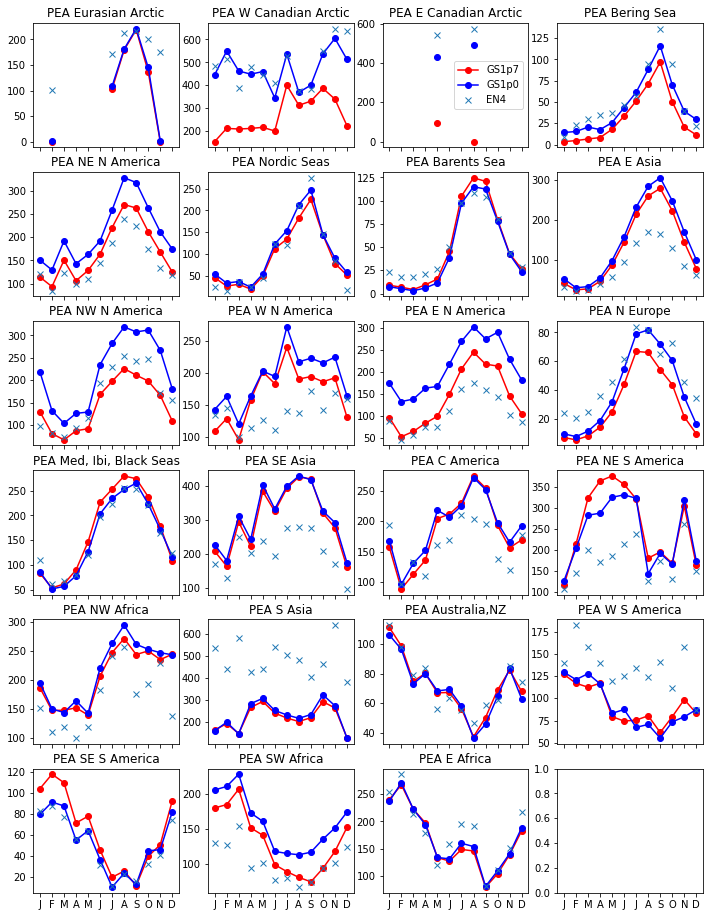

In [12]:
t=range(12)
fig,ax=plt.subplots(6,4,sharex=True,figsize=(12,16))
ax=ax.ravel()
for icluster in range(23):
    ax[icluster].plot(t,PEA_co_mask_mean[names[0],icluster],'r-o',t,PEA_co_mask_mean[names[1],icluster],'b-o',t,PEA_EN4_co_mean[icluster],'x')
   # ax[icluster].plot(t,PEA_co_mask_mean[names[0],icluster],'-.r',t,PEA_co_mask_mean[names[1],icluster],'-.b')
    
    ax[icluster].set_title(f"PEA {clusters.values[icluster,1]}")
    ax[icluster].set_xticks(range(12))    
    ax[icluster].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

ax[2].legend(['GS1p7','GS1p0','EN4'])

plt.savefig('../Figures/PEA_ann_cyc_clusters_GS1p7_GS1p0_v2.png',dpi=300,facecolor='white')


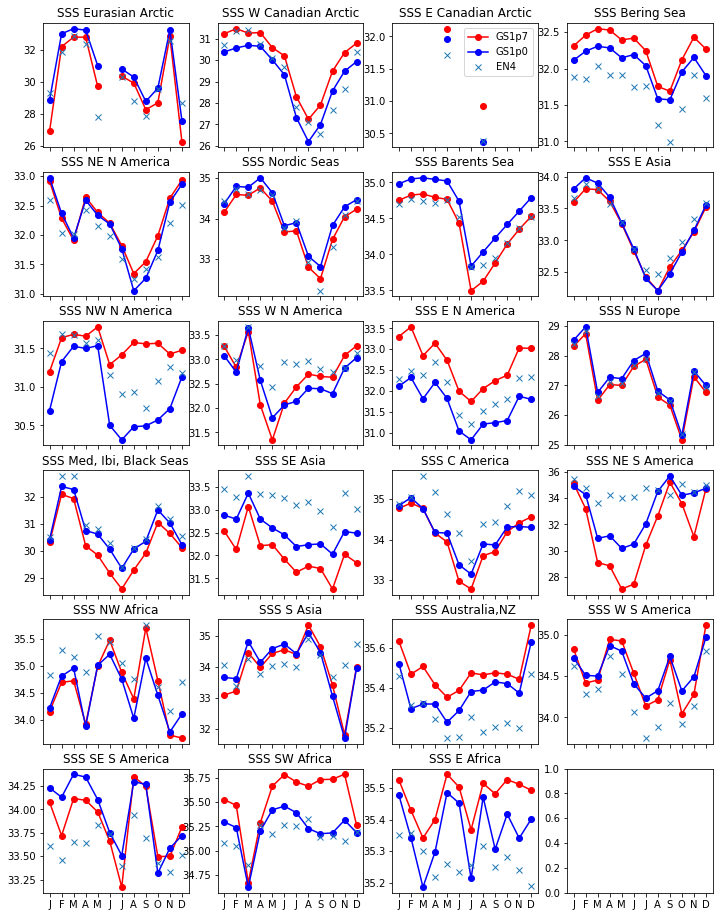

In [15]:
fig,ax=plt.subplots(6,4,sharex=True,figsize=(12,16))
ax=ax.ravel()
for icluster in range(23):
    ax[icluster].plot(t,SSS_co_mask_mean[names[0],icluster],'r-o',t,SSS_co_mask_mean[names[1],icluster],'b-o',t,SSS_EN4_co_mean[icluster],'x')
    ax[icluster].set_title(f"SSS {clusters.values[icluster,1]}")
    ax[icluster].set_xticks(range(12))    
    ax[icluster].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

ax[2].legend(['GS1p7','GS1p0','EN4'])
plt.savefig('../Figures/SSS_ann_cyc_clusters_GS1p7_GS1p0_v2.png',dpi=300,facecolor='white')

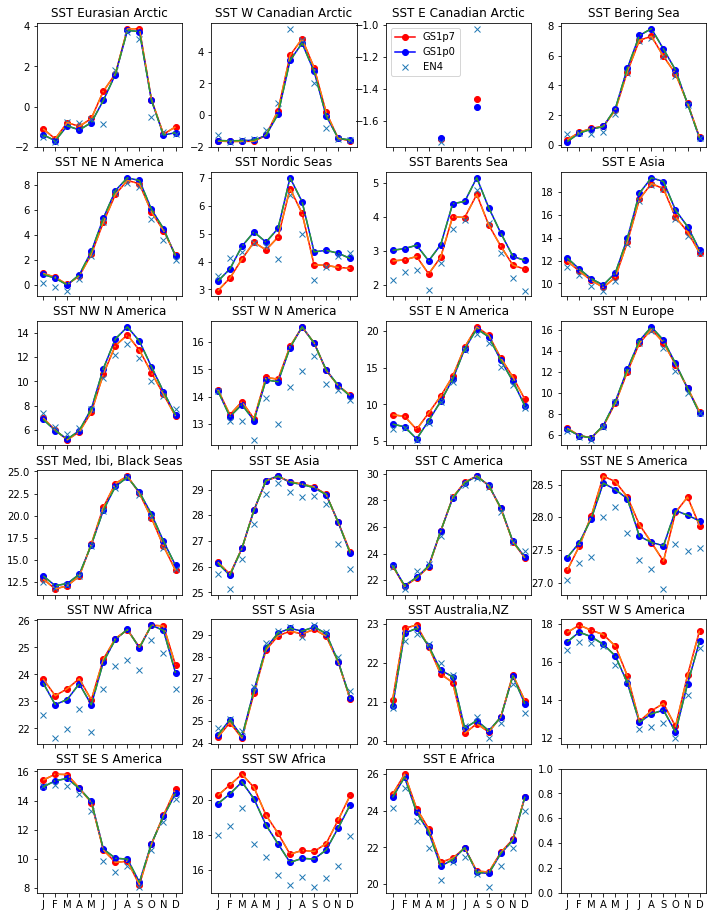

In [17]:
fig,ax=plt.subplots(6,4,sharex=True,figsize=(12,16))
ax=ax.ravel()
for icluster in range(23):
    ax[icluster].plot(t,SST_co_mask_mean[names[0],icluster],'r-o',t,SST_co_mask_mean[names[1],icluster],'b-o',t,SST_EN4_co_mean[icluster],'x')
    ax[icluster].plot(t,SST_co_mask_mean[names[0],icluster],'-.',t,SST_co_mask_mean[names[1],icluster],'-.')
    
    ax[icluster].set_title(f"SST {clusters.values[icluster,1]}")
    ax[icluster].set_xticks(range(12))    
    ax[icluster].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

ax[2].legend(['GS1p7','GS1p0','EN4'])
plt.savefig('../Figures/SST_ann_cyc_clusters_GS1p7_GS1p0_v2.png',dpi=300,facecolor='white')